In [81]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from operator import itemgetter

In [82]:
df = pd.read_csv("results.csv")
df["date"] = pd.to_datetime(df["date"])
df.dropna(inplace=True)
df = df[(df["date"] >= "2018-8-1")].reset_index(drop=True)

In [83]:
rank = pd.read_csv("fifa_ranking-2023-07-20.csv")
rank["rank_date"] = pd.to_datetime(rank["rank_date"]) 
rank = rank[(rank["rank_date"] >= "2018-8-1")].reset_index(drop=True)
rank["country_full"] = rank["country_full"].str.replace("IR Iran", "Iran").str.replace("Korea Republic", "South Korea").str.replace("USA", "United States")
rank = rank.set_index(['rank_date']).groupby(['country_full'], group_keys=False).resample('D').first().fillna(method='ffill').reset_index()

In [84]:
df = df.merge(rank[["country_full", "total_points", "previous_points", "rank", "rank_change", "rank_date"]], left_on=["date", "home_team"], right_on=["rank_date", "country_full"]).drop(["rank_date", "country_full"], axis=1)
df = df.merge(rank[["country_full", "total_points", "previous_points", "rank", "rank_change", "rank_date"]], left_on=["date", "away_team"], right_on=["rank_date", "country_full"], suffixes=("_home", "_away")).drop(["rank_date", "country_full"], axis=1)

In [85]:
def result_finder(home, away):
    if home > away:
        return pd.Series([0, 3, 0])
    if home < away:
        return pd.Series([1, 0, 3])
    else:
        return pd.Series([2, 1, 1])

results = df.apply(lambda x: result_finder(x["home_score"], x["away_score"]), axis=1)
df[["result", "home_team_points", "away_team_points"]] = results

In [86]:
df["rank_dif"] = df["rank_home"] - df["rank_away"]
df["sg"] = df["home_score"] - df["away_score"]
df["points_home_by_rank"] = df["home_team_points"]/df["rank_away"]
df["points_away_by_rank"] = df["away_team_points"]/df["rank_home"]

In [87]:
home_team = df[["date", "home_team", "home_score", "away_score", "rank_home", "rank_away","rank_change_home", "total_points_home", "result", "rank_dif", "points_home_by_rank", "home_team_points"]]
away_team = df[["date", "away_team", "away_score", "home_score", "rank_away", "rank_home","rank_change_away", "total_points_away", "result", "rank_dif", "points_away_by_rank", "away_team_points"]]

home_team.columns = [h.replace("home_", "").replace("_home", "").replace("away_", "suf_").replace("_away", "_suf") for h in home_team.columns]
away_team.columns = [a.replace("away_", "").replace("_away", "").replace("home_", "suf_").replace("_home", "_suf") for a in away_team.columns]
team_stats = home_team.append(away_team)#.sort_values("date")

In [88]:
stats_val = []

for index, row in team_stats.iterrows():
    team = row["team"]
    date = row["date"]
    past_games = team_stats.loc[(team_stats["team"] == team) & (team_stats["date"] < date)].sort_values(by=['date'], ascending=False)
    last5 = past_games.head(5)
    
    goals = past_games["score"].mean()
    goals_l5 = last5["score"].mean()
    
    goals_suf = past_games["suf_score"].mean()
    goals_suf_l5 = last5["suf_score"].mean()
    
    rank = past_games["rank_suf"].mean()
    rank_l5 = last5["rank_suf"].mean()
    
    if len(last5) > 0:
        points = past_games["total_points"].values[0] - past_games["total_points"].values[-1]
        points_l5 = last5["total_points"].values[0] - last5["total_points"].values[-1] 
    else:
        points = 0
        points_l5 = 0
        
    gp = past_games["team_points"].mean()
    gp_l5 = last5["team_points"].mean()
    
    gp_rank = past_games["points_by_rank"].mean()
    gp_rank_l5 = last5["points_by_rank"].mean()
    
    stats_val.append([goals, goals_l5, goals_suf, goals_suf_l5, rank, rank_l5, points, points_l5, gp, gp_l5, gp_rank, gp_rank_l5])
stats_val[-1]

[1.390625,
 1.8,
 1.484375,
 1.0,
 60.359375,
 39.8,
 56.23000000000002,
 0.0,
 1.3125,
 1.6,
 0.03132156176470427,
 0.046542840100008885]

In [89]:
stats_mean = ["goals_mean", "goals_mean_l5", "goals_suf_mean", "goals_suf_mean_l5", "rank_mean", "rank_mean_l5", "points_mean", "points_mean_l5", "game_points_mean", "game_points_mean_l5", "game_points_rank_mean", "game_points_rank_mean_l5"]
stats_df = pd.DataFrame(stats_val, columns=stats_mean)

full_df = pd.concat([team_stats.reset_index(drop=True), stats_df], axis=1, ignore_index=False)
home_team_stats = full_df.iloc[:int(full_df.shape[0]/2),:]
away_team_stats = full_df.iloc[int(full_df.shape[0]/2):,:]

home_team_stats = home_team_stats[home_team_stats.columns[-12:]]
away_team_stats = away_team_stats[away_team_stats.columns[-12:]]
home_team_stats.columns = ['home_'+str(col) for col in home_team_stats.columns]
away_team_stats.columns = ['away_'+str(col) for col in away_team_stats.columns]
match_stats = pd.concat([home_team_stats, away_team_stats.reset_index(drop=True)], axis=1, ignore_index=False)
full_df = pd.concat([df, match_stats.reset_index(drop=True)], axis=1, ignore_index=False)

def find_friendly(x):
    if x == "Friendly":
        return 1
    else: return 0

full_df["is_friendly"] = df["tournament"].apply(lambda x: find_friendly(x)) 
full_df = pd.get_dummies(full_df, columns=["is_friendly"])

df = full_df[["date", "home_team", "away_team", "rank_home", "rank_away","home_score", "away_score","result", "rank_dif", "rank_change_home", "rank_change_away", 'home_goals_mean',
       'home_goals_mean_l5', 'home_goals_suf_mean', 'home_goals_suf_mean_l5',
       'home_rank_mean', 'home_rank_mean_l5', 'home_points_mean',
       'home_points_mean_l5', 'away_goals_mean', 'away_goals_mean_l5',
       'away_goals_suf_mean', 'away_goals_suf_mean_l5', 'away_rank_mean',
       'away_rank_mean_l5', 'away_points_mean', 'away_points_mean_l5','home_game_points_mean', 'home_game_points_mean_l5',
       'home_game_points_rank_mean', 'home_game_points_rank_mean_l5','away_game_points_mean',
       'away_game_points_mean_l5', 'away_game_points_rank_mean',
       'away_game_points_rank_mean_l5',
       'is_friendly_0', 'is_friendly_1']]
df = df.dropna()
df.result.value_counts()

0    1776
1    1062
2     857
Name: result, dtype: int64

In [90]:
def no_draw(x):
    if x == 2:
        return 1
    else:
        return x
    
df["target"] = df["result"].apply(lambda x: no_draw(x))


def create_db(df):
    columns = ["home_team", "away_team", "target", "rank_dif", "home_goals_mean", "home_rank_mean", "away_goals_mean", "away_rank_mean", "home_rank_mean_l5", "away_rank_mean_l5", "home_goals_suf_mean", "away_goals_suf_mean", "home_goals_mean_l5", "away_goals_mean_l5", "home_goals_suf_mean_l5", "away_goals_suf_mean_l5", "home_game_points_rank_mean", "home_game_points_rank_mean_l5", "away_game_points_rank_mean", "away_game_points_rank_mean_l5","is_friendly_0", "is_friendly_1"]
    
    base = df.loc[:, columns]
    base.loc[:, "goals_dif"] = base["home_goals_mean"] - base["away_goals_mean"]
    base.loc[:, "goals_dif_l5"] = base["home_goals_mean_l5"] - base["away_goals_mean_l5"]
    base.loc[:, "goals_suf_dif"] = base["home_goals_suf_mean"] - base["away_goals_suf_mean"]
    base.loc[:, "goals_suf_dif_l5"] = base["home_goals_suf_mean_l5"] - base["away_goals_suf_mean_l5"]
    base.loc[:, "goals_per_ranking_dif"] = (base["home_goals_mean"] / base["home_rank_mean"]) - (base["away_goals_mean"] / base["away_rank_mean"])
    base.loc[:, "dif_rank_agst"] = base["home_rank_mean"] - base["away_rank_mean"]
    base.loc[:, "dif_rank_agst_l5"] = base["home_rank_mean_l5"] - base["away_rank_mean_l5"]
    base.loc[:, "dif_points_rank"] = base["home_game_points_rank_mean"] - base["away_game_points_rank_mean"]
    base.loc[:, "dif_points_rank_l5"] = base["home_game_points_rank_mean_l5"] - base["away_game_points_rank_mean_l5"]
    
    model_df = base[["home_team", "away_team", "target", "rank_dif", "goals_dif", "goals_dif_l5", "goals_suf_dif", "goals_suf_dif_l5", "goals_per_ranking_dif", "dif_rank_agst", "dif_rank_agst_l5", "dif_points_rank", "dif_points_rank_l5", "is_friendly_0", "is_friendly_1"]]
    return model_df


model_db = create_db(df)

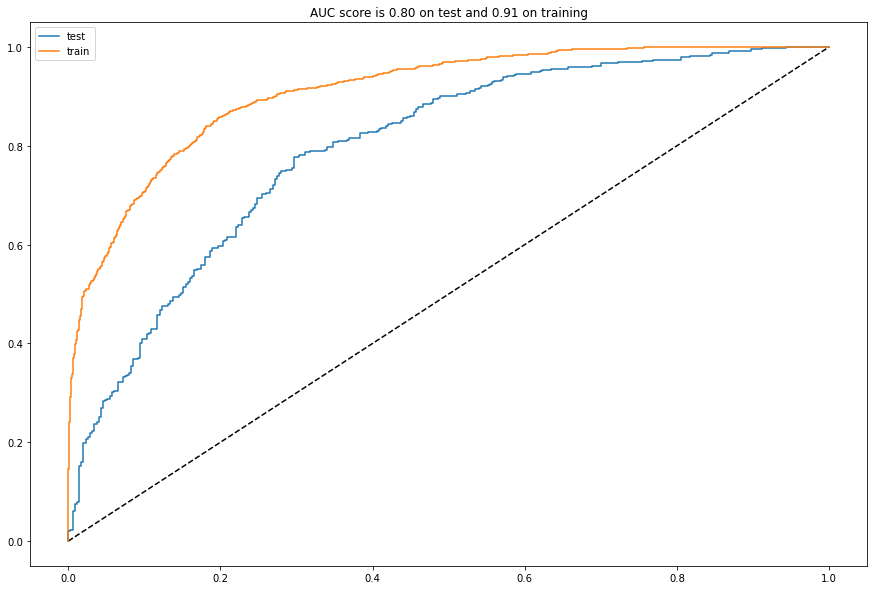

<AxesSubplot:>

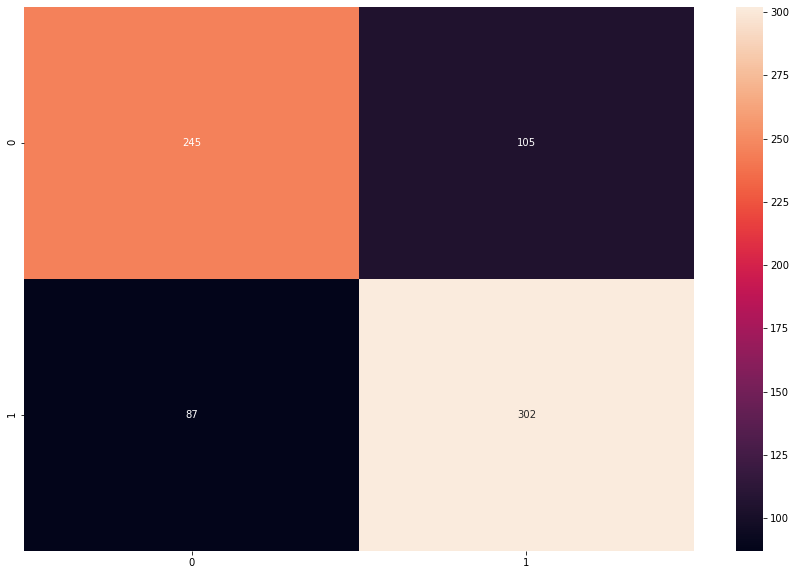

In [91]:
df = model_db.copy()

X = df.iloc[:, 3:]
y = df[["target"]]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=1)

params_rf = {"max_depth": [20],
                "min_samples_split": [5, 10],
                "max_leaf_nodes": [175, 200],
                "min_samples_leaf": [5, 10],
                "n_estimators": [250],
                 "max_features": ["sqrt"],
                }

rf = RandomForestClassifier(random_state=1)
rf_cv = GridSearchCV(rf, params_rf, cv = 3, n_jobs = -1, verbose = False)
rf_cv.fit(X_train.values, np.ravel(y_train))
rf = rf_cv.best_estimator_

fpr, tpr, _ = roc_curve(y_test, rf.predict_proba(X_test.values)[:,1]) #test AUC
plt.figure(figsize=(15,10))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label="test")

fpr_train, tpr_train, _ = roc_curve(y_train, rf.predict_proba(X_train.values)[:,1]) #train AUC
plt.plot(fpr_train, tpr_train, label="train")
auc_test = roc_auc_score(y_test, rf.predict_proba(X_test.values)[:,1])
auc_train = roc_auc_score(y_train, rf.predict_proba(X_train.values)[:,1])
plt.legend()
plt.title('AUC score is %.2f on test and %.2f on training'%(auc_test, auc_train))
plt.show()
    
plt.figure(figsize=(15, 10))
cm = confusion_matrix(y_test, rf.predict(X_test.values))
sns.heatmap(cm, annot=True, fmt="d")



In [122]:
matches = [('A', 'Germany', 'Scotland'),
           ('A', 'Hungary', 'Switzerland'),
           ('A', 'Germany', 'Hungary'),
           ('A', 'Scotland', 'Switzerland'),
           ('A', 'Switzerland', 'Germany'),
           ('A', 'Scotland', 'Hungary'),
           ('B', 'Spain', 'Croatia'),
           ('B', 'Italy', 'Albania'),
           ('B', 'Croatia', 'Albania'),
           ('B', 'Spain', 'Italy'),
           ('B', 'Albania', 'Spain'),
           ('B', 'Croatia', 'Italy'),
           ('C', 'Slovenia', 'Denmark'),
           ('C', 'Serbia', 'England'),
           ('C', 'Slovenia', 'Serbia'),
           ('C', 'Denmark', 'England'),
           ('C', 'England', 'Slovenia'),
           ('C', 'Denmark', 'Serbia'),
           ('D', 'Poland', 'Netherlands'),
           ('D', 'Austria', 'France'),
           ('D', 'Poland', 'Austria'),
           ('D', 'Netherlands', 'France'),
           ('D', 'Netherlands', 'Austria'),
           ('D', 'France', 'Poland'),
           ('E', 'Romania', 'Ukraine'),
           ('E', 'Belgium', 'Slovakia'),
           ('E', 'Slovakia', 'Ukraine'),
           ('E', 'Belgium', 'Romania'),
           ('E', 'Slovakia', 'Romania'),
           ('E', 'Ukraine', 'Belgium'),
           ('F', 'Turkey', 'Greece'),
           ('F', 'Portugal', 'Czech Republic'),
           ('F', 'Greece', 'Czech Republic'),
           ('F', 'Turkey', 'Portugal'),
           ('F', 'Greece', 'Portugal'),
           ('F', 'Czech Republic', 'Turkey')
          ]
groups = ["A", "B", "C", "D", "E", "F"]


table = {'A': [['Germany', 0, []], 
               ['Scotland', 0, []], 
               ['Hungary', 0, []],
               ['Switzerland', 0, []]],
         'B': [['Spain', 0, []], 
               ['Croatia', 0, []], 
               ['Italy', 0, []],
               ['Albania', 0, []]],
         'C': [['Slovenia', 0, []], 
               ['Denmark', 0, []], 
               ['Serbia', 0, []],
               ['England', 0, []]],
         'D': [['Netherlands', 0, []], 
               ['Austria', 0, []], 
               ['Poland', 0, []],
               ['France', 0, []]],
         'E': [['Belgium', 0, []], 
               ['Slovakia', 0, []],
               ['Ukraine', 0, []],
               ['Romania', 0, []]],
         'F': [['Turkey', 0, []], 
               ['Portugal', 0, []],
               ['Greece', 0, []],
               ['Czech Republic', 0, []]]}
      
        
def find_stats(team_1):
    past_games = team_stats[(team_stats["team"] == team_1)].sort_values("date")
    last5 = team_stats[(team_stats["team"] == team_1)].sort_values("date").tail(5)

    team_1_rank = past_games["rank"].values[-1]
    team_1_goals = past_games.score.mean()
    team_1_goals_l5 = last5.score.mean()
    team_1_goals_suf = past_games.suf_score.mean()
    team_1_goals_suf_l5 = last5.suf_score.mean()
    team_1_rank_suf = past_games.rank_suf.mean()
    team_1_rank_suf_l5 = last5.rank_suf.mean()
    team_1_gp_rank = past_games.points_by_rank.mean()
    team_1_gp_rank_l5 = last5.points_by_rank.mean()

    return [team_1_rank, team_1_goals, team_1_goals_l5, team_1_goals_suf, team_1_goals_suf_l5, team_1_rank_suf, team_1_rank_suf_l5, team_1_gp_rank, team_1_gp_rank_l5]

def find_features(team_1, team_2):
    rank_dif = team_1[0] - team_2[0]
    goals_dif = team_1[1] - team_2[1]
    goals_dif_l5 = team_1[2] - team_2[2]
    goals_suf_dif = team_1[3] - team_2[3]
    goals_suf_dif_l5 = team_1[4] - team_2[4]
    goals_per_ranking_dif = (team_1[1]/team_1[5]) - (team_2[1]/team_2[5])
    dif_rank_agst = team_1[5] - team_2[5]
    dif_rank_agst_l5 = team_1[6] - team_2[6]
    dif_gp_rank = team_1[7] - team_2[7]
    dif_gp_rank_l5 = team_1[8] - team_2[8]
    
    return [rank_dif, goals_dif, goals_dif_l5, goals_suf_dif, goals_suf_dif_l5, goals_per_ranking_dif, dif_rank_agst, dif_rank_agst_l5, dif_gp_rank, dif_gp_rank_l5, 1, 0]

advanced_group = []
last_group = ""
thresh = 0.05
group_stages_done = []
for k in table.keys():
    for t in table[k]:
        t[1] = 0
        t[2] = []
        
for teams in matches:
    draw = False
    team_1 = find_stats(teams[1])
    team_2 = find_stats(teams[2])

    features_g1 = find_features(team_1, team_2)
    features_g2 = find_features(team_2, team_1)

    probs_g1 = rf.predict_proba([features_g1])
    probs_g2 = rf.predict_proba([features_g2])
    
    team_1_prob_g1 = probs_g1[0][0]
    team_1_prob_g2 = probs_g2[0][1]
    team_2_prob_g1 = probs_g1[0][1]
    team_2_prob_g2 = probs_g2[0][0]

    team_1_prob = (probs_g1[0][0] + probs_g2[0][1])/2
    team_2_prob = (probs_g2[0][0] + probs_g1[0][1])/2
    
    if ((team_1_prob_g1 > team_2_prob_g1) & (team_2_prob_g2 > team_1_prob_g2)) | ((team_1_prob_g1 < team_2_prob_g1) & (team_2_prob_g2 < team_1_prob_g2)):
        draw=True
        for i in table[teams[0]]:
            if i[0] == teams[1] or i[0] == teams[2]:
                i[1] += 1
                
    elif team_1_prob > team_2_prob:
        winner = teams[1]
        winner_proba = team_1_prob
        for i in table[teams[0]]:
            if i[0] == teams[1]:
                i[1] += 3
                
    elif team_2_prob > team_1_prob:  
        winner = teams[2]
        winner_proba = team_2_prob
        for i in table[teams[0]]:
            if i[0] == teams[2]:
                i[1] += 3
    
    for i in table[teams[0]]:
            if i[0] == teams[1]:
                i[2].append(team_1_prob)
            if i[0] == teams[2]:
                i[2].append(team_2_prob)

    if last_group != teams[0]:
        if last_group != "":
            print("\n")
            print("Group %s advanced: "%(last_group))
            
            for i in table[last_group]:
                i[2] = np.mean(i[2])
            
            final_points = table[last_group]
            final_table = sorted(final_points, key=itemgetter(1, 2), reverse = True)
            group_stages_done.append(final_table)
            for i in final_table:
                print("%s -------- %d"%(i[0], i[1]))
        print("\n")
        print("-"*10+" Starting Analysis for Group %s "%(teams[0])+"-"*10)
        
        
    if draw == False:
        print("Group %s - %s vs. %s: Winner %s with %.2f probability"%(teams[0], teams[1], teams[2], winner, winner_proba))
    else:
        print("Group %s - %s vs. %s: Draw"%(teams[0], teams[1], teams[2]))
    last_group =  teams[0]

print("\n")
print("Group %s advanced: "%(last_group))

for i in table[last_group]:
    i[2] = np.mean(i[2])
            
final_points = table[last_group]
final_table = sorted(final_points, key=itemgetter(1, 2), reverse = True)
group_stages_done.append(final_table)
for i in final_table:
    print("%s -------- %d"%(i[0], i[1]))
     
third_place = []
for i in group_stages_done:
    third_place.append(i[3])

third_place = sorted(third_place, key=itemgetter(1, 2), reverse = True)
advanced_group = [
    [group_stages_done[0][0][0], third_place[0][0]],
    [group_stages_done[1][0][0], third_place[1][0]],
    [group_stages_done[2][0][0], third_place[2][0]],
    [group_stages_done[3][0][0], third_place[3][0]],
    [group_stages_done[4][0][0], group_stages_done[0][1][0]],
    [group_stages_done[5][0][0], group_stages_done[1][1][0]],
    [group_stages_done[2][1][0], group_stages_done[3][1][0]],
    [group_stages_done[4][1][0], group_stages_done[5][1][0]],
]
advanced = advanced_group
playoffs = {"Round of 16": [], "Quarter-Final": [], "Semi-Final": [], "Final": []}
for p in playoffs.keys():
    playoffs[p] = []

actual_round = ""
next_rounds = []

for p in playoffs.keys():
    if p == "Round of 16":
        control = []
        for a in range(0, len(advanced*2), 1):
            if a < len(advanced):
                if a % 2 == 0:
                    control.append((advanced*2)[a][0])
                else:
                    control.append((advanced*2)[a][1])
            else:
                if a % 2 == 0:
                    control.append((advanced*2)[a][1])
                else:
                    control.append((advanced*2)[a][0])

        playoffs[p] = [[control[c], control[c+1]] for c in range(0, len(control)-1, 1) if c%2 == 0]
        
        for i in range(0, len(playoffs[p]), 1):
            game = playoffs[p][i]
            
            home = game[0]
            away = game[1]
            team_1 = find_stats(home)
            team_2 = find_stats(away)

            features_g1 = find_features(team_1, team_2)
            features_g2 = find_features(team_2, team_1)
            
            probs_g1 = rf.predict_proba([features_g1])
            probs_g2 = rf.predict_proba([features_g2])
            
            team_1_prob = (probs_g1[0][0] + probs_g2[0][1])/2
            team_2_prob = (probs_g2[0][0] + probs_g1[0][1])/2
            
            if actual_round != p:
                print("-"*10)
                print("Starting simulation of %s"%(p))
                print("-"*10)
                print("\n")
            
            if team_1_prob < team_2_prob:
                print("%s vs. %s: %s advances with prob %.2f"%(home, away, away, team_2_prob))
                next_rounds.append(away)
            else:
                print("%s vs. %s: %s advances with prob %.2f"%(home, away, home, team_1_prob))
                next_rounds.append(home)
            
            game.append([team_1_prob, team_2_prob])
            playoffs[p][i] = game
            actual_round = p
        
    else:
        playoffs[p] = [[next_rounds[c], next_rounds[c+1]] for c in range(0, len(next_rounds)-1, 1) if c%2 == 0]
        next_rounds = []
        for i in range(0, len(playoffs[p])):
            game = playoffs[p][i]
            home = game[0]
            away = game[1]
            team_1 = find_stats(home)
            team_2 = find_stats(away)
            
            features_g1 = find_features(team_1, team_2)
            features_g2 = find_features(team_2, team_1)
            
            probs_g1 = rf.predict_proba([features_g1])
            probs_g2 = rf.predict_proba([features_g2])
            
            team_1_prob = (probs_g1[0][0] + probs_g2[0][1])/2
            team_2_prob = (probs_g2[0][0] + probs_g1[0][1])/2
            
            if actual_round != p:
                print("-"*10)
                print("Starting simulation of %s"%(p))
                print("-"*10)
                print("\n")
            
            if team_1_prob < team_2_prob:
                print("%s vs. %s: %s advances with prob %.2f"%(home, away, away, team_2_prob))
                next_rounds.append(away)
            else:
                print("%s vs. %s: %s advances with prob %.2f"%(home, away, home, team_1_prob))
                next_rounds.append(home)
            game.append([team_1_prob, team_2_prob])
            playoffs[p][i] = game
            actual_round = p



---------- Starting Analysis for Group A ----------
Group A - Germany vs. Scotland: Winner Germany with 0.61 probability
Group A - Hungary vs. Switzerland: Draw
Group A - Germany vs. Hungary: Winner Germany with 0.60 probability
Group A - Scotland vs. Switzerland: Winner Switzerland with 0.61 probability
Group A - Switzerland vs. Germany: Draw
Group A - Scotland vs. Hungary: Draw


Group A advanced: 
Germany -------- 7
Switzerland -------- 5
Hungary -------- 2
Scotland -------- 1


---------- Starting Analysis for Group B ----------
Group B - Spain vs. Croatia: Winner Spain with 0.66 probability
Group B - Italy vs. Albania: Winner Italy with 0.82 probability
Group B - Croatia vs. Albania: Winner Croatia with 0.75 probability
Group B - Spain vs. Italy: Draw
Group B - Albania vs. Spain: Winner Spain with 0.82 probability
Group B - Croatia vs. Italy: Draw


Group B advanced: 
Spain -------- 7
Italy -------- 5
Croatia -------- 4
Albania -------- 0


---------- Starting Analysis for Group